In [1]:
import numpy as np

from keras.models import Model, load_model
from keras.datasets import cifar10
import keras.backend as K

from pgd_attack import AdversarialExampleGenerator

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm import tqdm

import os
import math
from statistics import mean, median

# Restrict GPU memory usage
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "1"
sess = tf.Session(config=config)
set_session(sess)

/data/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
epsilon = 2 / 255
batch_size = 64
model_path = "saved_models/CIFAR10_SmallResNet_eps_0.008/Apr26_17-03-48/weights_050_0.67.h5"

In [3]:
####################
# Data preparation #
####################

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Leave aside a validation set
x_valid = x_train[-5000:]
y_valid = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

# Input image dimensions
input_shape = x_train.shape[1:]

# Normalize data
x_train = x_train.astype("float32") / 255
x_valid = x_valid.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print(x_train.shape[0], "train samples")
print(x_valid.shape[0], "validation samples")
print(x_test.shape[0], "test samples")

45000 train samples
5000 validation samples
10000 test samples


In [4]:
########################
# Model initialisation #
########################

model = load_model(model_path)

model.xent_loss = model.total_loss
for loss in model.losses:
    model.xent_loss -= loss

In [5]:
###################
# Data generators #
###################

valid_adv_generator = AdversarialExampleGenerator(model, x_valid, y_valid,
                                                  batch_size=batch_size,
                                                  epsilon=epsilon,
                                                  k=40,
                                                  a=epsilon / 10.0,
                                                  incremental=False,
                                                  shuffle=False)

test_adv_generator  = AdversarialExampleGenerator(model, x_test, y_test,
                                                  batch_size=batch_size,
                                                  epsilon=epsilon,
                                                  k=40,
                                                  a=epsilon / 10.0,
                                                  incremental=False,
                                                  shuffle=False)

In [6]:
x_acc = []
for x_batch, _, _ in tqdm(valid_adv_generator):
    x_acc.append(x_batch)
x_valid_adv = np.concatenate(x_acc, axis=0)

x_acc = []
for x_batch, _, _ in tqdm(test_adv_generator):
    x_acc.append(x_batch)
x_test_adv = np.concatenate(x_acc, axis=0)

100%|██████████| 157/157 [04:27<00:00,  1.43s/it]


In [7]:
input_tensor = model.input
output_tensor = model.layers[-2].output

representation_model = Model(inputs=input_tensor, outputs=output_tensor)

train_nat_representations = representation_model.predict(x_train)
valid_nat_representations = representation_model.predict(x_valid)
valid_adv_representations = representation_model.predict(x_valid_adv)
test_nat_representations = representation_model.predict(x_test)
test_adv_representations = representation_model.predict(x_test_adv)

In [8]:
y_train = y_train.reshape(-1)
y_valid = y_valid.reshape(-1)
y_test = y_test.reshape(-1)

## SVM model

In [9]:
class SVMModel():
    def __init__(self, X_train, y_train, kernel="linear", cache_size=1024):
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        self.svm = SVC(kernel=kernel, decision_function_shape="ovo", cache_size=cache_size)
        self.svm.fit(X_train_scaled, y_train)

    def predict(self, X):
        return self.svm.predict(self.scaler.transform(X))
    
    def predict_with_adversarial_prediction(self, X, adv_prediction_function):
        """Uses the `adv_prediction_function` to decide if the input is
           adversarial; if so, outputs class -1. Otherwise, outputs the
           predicted class."""
        y_predict = self.predict(X)
        class_distances = self.get_predicted_class_decision_boundary_distances(X, y_predict)
        y_predict_is_adv = np.fromiter(map(adv_prediction_function, class_distances), dtype=np.bool)
        
        for i, x in enumerate(y_predict_is_adv):
            if x:
                y_predict[i] = -1
        
        return y_predict

    def get_decision_boundary_distances(self, X):
        return self.svm.decision_function(self.scaler.transform(X))

    def get_predicted_class_decision_boundary_distances(self, X, predictions, num_classes=10):
        distances = self.get_decision_boundary_distances(X)

        predicted_class_distances = []

        for k in range(len(X)):
            distances_for_k = distances[k]
            predicted_class_distances_for_k = []
            i = predictions[k]
            # When j < i
            for j in range(i):
                index = int((num_classes - 0.5) * j - math.pow(j, 2) / 2 + (i - j - 1))
                predicted_class_distances_for_k.append(-1 * distances_for_k[index])
            # When i < j
            base_index = int((num_classes - 0.5) * i - math.pow(i, 2) / 2)
            for j in range(i + 1, num_classes):
                index = base_index + (j - i - 1)
                predicted_class_distances_for_k.append(distances_for_k[index])
            predicted_class_distances.append(predicted_class_distances_for_k)

        return predicted_class_distances

    def test(self, X_test, y_test):
        """Calculates the accuracy of the model on some test data, without
           adversarial prediction."""
        
        return self.svm.score(self.scaler.transform(X_test), y_test)

    def test_with_adversarial_prediction(self, X_test, y_test, is_adversarial, adv_prediction_function):
        """Calculates the accuracy of the model on some test data when using
           adversarial prediction. Takes a boolean flag indicating if the test
           data is adversarial or not, and an adversarial prediction function"""
        
        y_predict = self.predict_with_adversarial_prediction(X_test, adv_prediction_function)
        
        # Number of inputs with correct class predicted
        num_correct = np.sum(y_predict == y_test)
        
        if is_adversarial:
            # If the examples are adversarial it's also correct to predict the
            # class -1 (which indicates adversarialness)
            num_correct += np.sum(y_predict == -1)
                        
        return num_correct / len(X_test)
    
    def distances_linear_map(self, X):
        start = 0
        end = 0
        class_support_vect = []

        class_dual_coef = []
        for k in self.svm.n_support_:
            end += k
            class_support_vect.append(self.svm.support_vectors_[start:end])
            class_dual_coef.append(self.svm.dual_coef_[:, start:end])
            start = end

        dists = np.zeros((45,100))
        k = 0
        for i in range(10):        
            for j in range(i+1, 10):
                dists[k] += np.sum(class_dual_coef[i][j-1].reshape(1,-1).T * class_support_vect[i], axis=0)
                dists[k] += np.sum(class_dual_coef[j][i].reshape(1,-1).T * class_support_vect[j], axis=0)
                k += 1

        return ((dists / self.scaler.scale_).T, self.svm.intercept_ - ((dists / self.scaler.scale_) @ self.scaler.mean_))

In [10]:
svm_model = SVMModel(train_nat_representations, y_train)

## Predictions

In [11]:
model_predict_valid_nat = np.argmax(model.predict(x_valid), axis=1)
model_predict_valid_adv = np.argmax(model.predict(x_valid_adv), axis=1)

svm_predict_valid_nat = svm_model.predict(valid_nat_representations)
svm_predict_valid_adv = svm_model.predict(valid_adv_representations)

## How good is the SVM as an approximation to the output layer?

In [12]:
print("SVM natural train accuracy", svm_model.test(train_nat_representations, y_train))
print("Model natural train accuracy", model.evaluate(x_train, y_train, verbose=0)[1])

SVM natural train accuracy 0.9667555555555556
Model natural train accuracy 0.9578888888888889


In [13]:
print("SVM natural valid accuracy", svm_model.test(valid_nat_representations, y_valid))
print("Model natural valid accuracy", model.evaluate(x_valid, y_valid, verbose=0)[1])

SVM natural valid accuracy 0.8468
Model natural valid accuracy 0.8544


In [14]:
# Adversarial train accuracy
print("SVM adversarial valid accuracy", svm_model.test(valid_adv_representations, y_valid))
print("Model adversarial valid accuracy", model.evaluate(x_valid_adv, y_valid, verbose=0)[1])

SVM adversarial valid accuracy 0.653
Model adversarial valid accuracy 0.6654


In [15]:
print(
    "Top 1 natural valid concurrence of SVM",
    np.count_nonzero(svm_predict_valid_nat == model_predict_valid_nat) / len(x_valid)
)

Top 1 natural valid concurrence of SVM 0.9442


In [16]:
print(
    "Top 1 adversarial valid concurrence of SVM",
    np.count_nonzero(svm_predict_valid_adv == model_predict_valid_adv) / len(x_valid_adv)
)

Top 1 adversarial valid concurrence of SVM 0.9172


In [17]:
count = 0
for p, q in zip(svm_model.predict(valid_nat_representations), np.argsort(model.predict(x_valid), axis=1)[:, -2:]):
    if p in q:
        count += 1
print("Top 2 natural valid concurrence of SVM", count / len(x_valid))

Top 2 natural valid concurrence of SVM 0.9918


In [18]:
count = 0
for p, q in zip(svm_model.predict(valid_adv_representations), np.argsort(model.predict(x_valid_adv), axis=1)[:, -2:]):
    if p in q:
        count += 1
print("Top 2 adversarial valid concurrence of SVM", count / len(x_valid_adv))

Top 2 adversarial valid concurrence of SVM 0.9872


/data/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


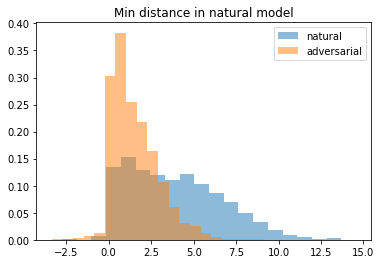

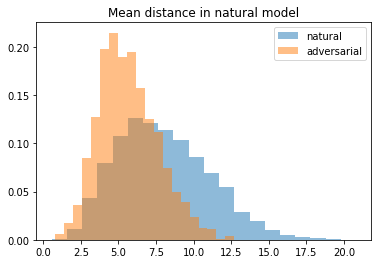

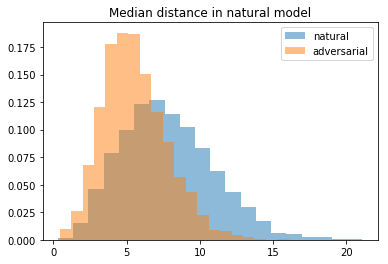

In [19]:
valid_nat_dists = svm_model.get_predicted_class_decision_boundary_distances(
                             valid_nat_representations,
                             svm_predict_valid_nat)

valid_adv_dists = svm_model.get_predicted_class_decision_boundary_distances(
                             *zip(*[(x,y) for (x,y,z) in  zip(
                                 valid_adv_representations,
                                 svm_predict_valid_adv,
                                 y_valid
                             ) if y != z])
                         )

nat_min_dists = list(map(lambda xs: min(xs), valid_nat_dists))
adv_min_dists = list(map(lambda xs: min(xs), valid_adv_dists))

nat_mean_dists = list(map(lambda xs: mean(xs), valid_nat_dists))
adv_mean_dists = list(map(lambda xs: mean(xs), valid_adv_dists))

nat_median_dists = list(map(lambda xs: median(xs), valid_nat_dists))
adv_median_dists = list(map(lambda xs: median(xs), valid_adv_dists))

plt.title("Min distance in natural model")
plt.hist(nat_min_dists, normed=True, bins=20, alpha=0.5, label="natural")
plt.hist(adv_min_dists, normed=True, bins=20, alpha=0.5, label="adversarial")
plt.legend()
plt.show()

plt.title("Mean distance in natural model")
plt.hist(nat_mean_dists, normed=True, bins=20, alpha=0.5, label="natural")
plt.hist(adv_mean_dists, normed=True, bins=20, alpha=0.5, label="adversarial")
plt.legend()
plt.show()

plt.title("Median distance in natural model")
plt.hist(nat_median_dists, normed=True, bins=20, alpha=0.5, label="natural")
plt.hist(adv_median_dists, normed=True, bins=20, alpha=0.5, label="adversarial")
plt.legend()
plt.show()

## Validation accuracy

In [21]:
def calculate_accuracy(representations, predictions, y, is_adv, adv_pred_function):
    dists = svm_model.get_predicted_class_decision_boundary_distances(
                                 representations,
                                 predictions)
        
    if not is_adv:
        correct_predict = [not adv_pred_function(xs) and a == b
                           for (xs,a,b) in zip(dists, predictions, y)]
    else:
        correct_predict = [adv_pred_function(xs) or a == b
                           for (xs,a,b) in zip(dists, predictions, y)]
    
    return np.sum(correct_predict) / len(representations)

adv_pred_function = lambda xs: min(xs) < 0.75

print(calculate_accuracy(valid_nat_representations,
                         svm_predict_valid_nat,
                         y_valid,
                         False,
                         adv_pred_function),
      "accuracy on natural images")


print(calculate_accuracy(valid_adv_representations,
                         svm_predict_valid_adv,
                         y_valid,
                         True,
                         adv_pred_function),
      "accuracy on adversarial images")

0.7876 accuracy on natural images
0.7736 accuracy on adversarial images
